# Facies Classification with XGBoost

1. Load
2. Explore
3. Augmentation
4. Train, then Predict Test Facies
5. Evaluate

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

from xgboost.sklearn import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.signal import medfilt

from sklearn.metrics import f1_score, accuracy_score

from classification_utilities import make_facies_log_plot
from classification_utilities import compare_facies_plot

## 1. Load

In [2]:
#Load Data
data = pd.read_csv('facies_vectors.csv')

# Define groups of parameters
# Wireline measurements -> lnput features
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
# Geological descriptins -> labels
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
# Color codes
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

# Store features and labels
X = data[feature_names].values 
y = data['Facies'].values 

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

# Fill 'PE' missing values with mean
imp = SimpleImputer(missing_values=np.nan, copy=False, strategy="mean")
imp.fit(X)
X = imp.transform(X)

## 2. Explore

In [3]:
# Define function for plotting feature statistics
def plot_feature_stats(X, y, feature_names, facies_colors, facies_names):
    
    # Remove NaN
    nan_idx = np.any(np.isnan(X), axis=1)
    X = X[np.logical_not(nan_idx), :]
    y = y[np.logical_not(nan_idx)]
    
    # Merge features and labels into a single DataFrame
    features = pd.DataFrame(X, columns=feature_names)
    labels = pd.DataFrame(y, columns=['Facies'])
    for f_idx, facies in enumerate(facies_names):
        labels[labels[:] == f_idx] = facies
    data = pd.concat((labels, features), axis=1)

    # Plot features statistics
    facies_color_map = {}
    for ind, label in enumerate(facies_names):
        facies_color_map[label] = facies_colors[ind]

    sns.pairplot(data, hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_names)))

C:\Users\ChristianV700\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ChristianV700\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ChristianV700\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ChristianV700\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ChristianV700\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ChristianV700\Anaconda3\lib\site-packages

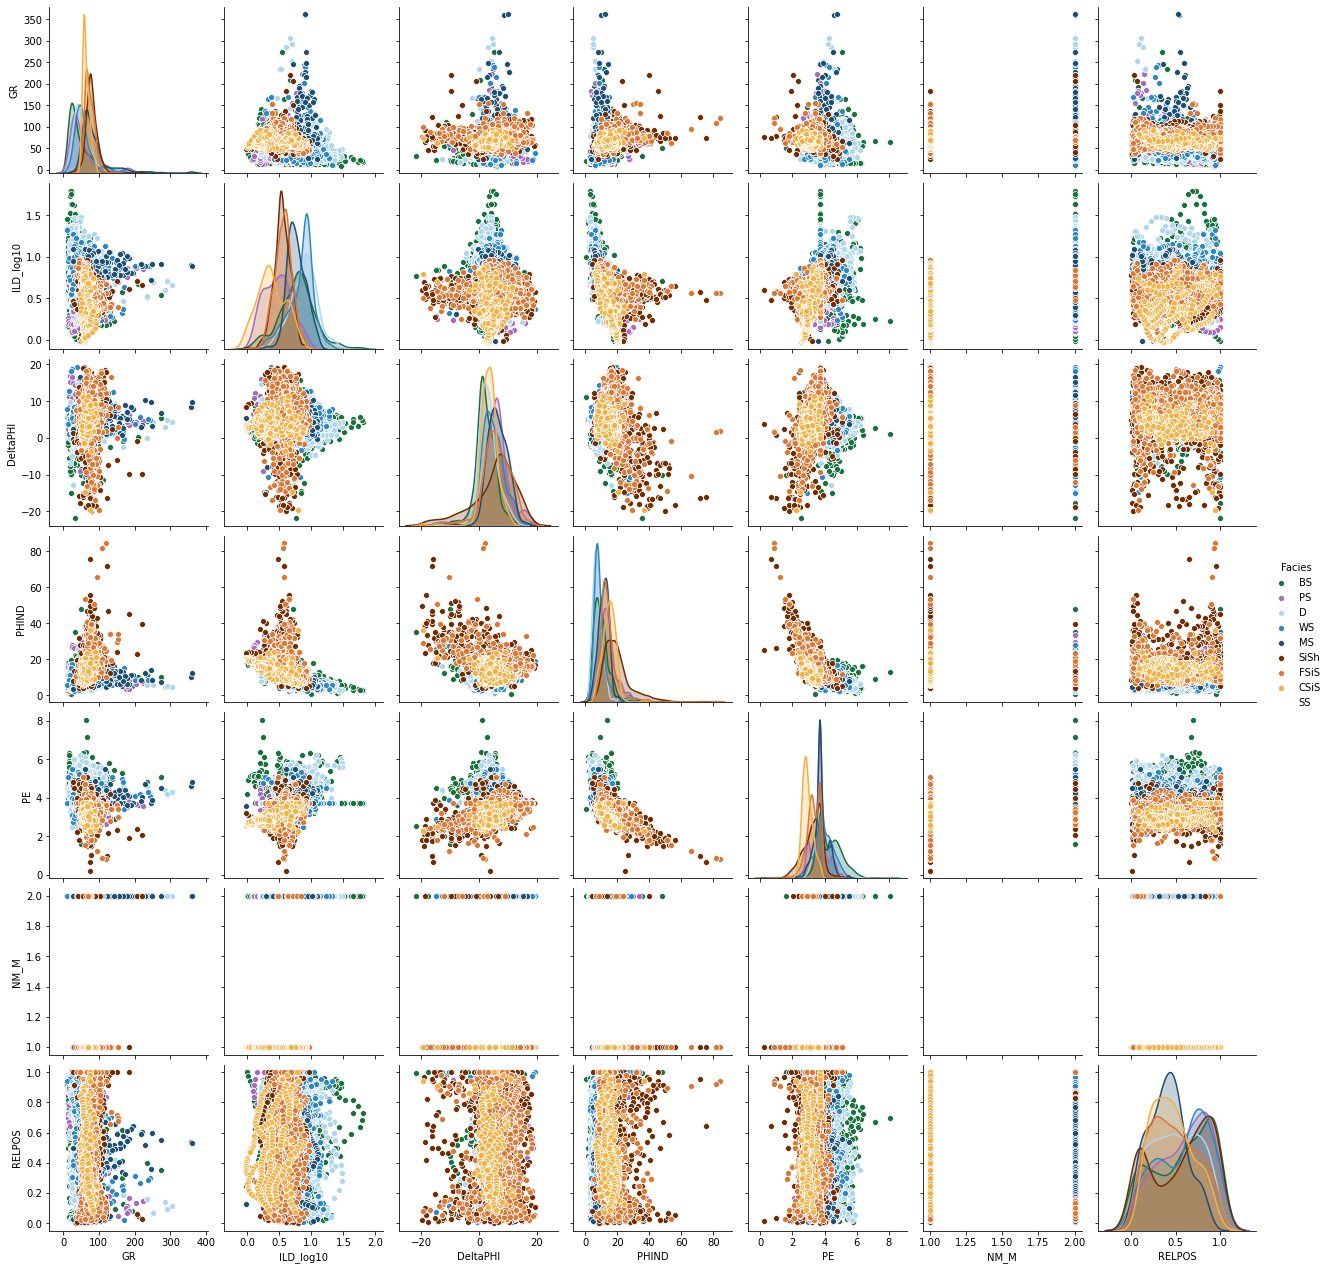

In [4]:
# Data Exploration: Feature distribution
plot_feature_stats(X, y, feature_names, facies_colors, facies_names)

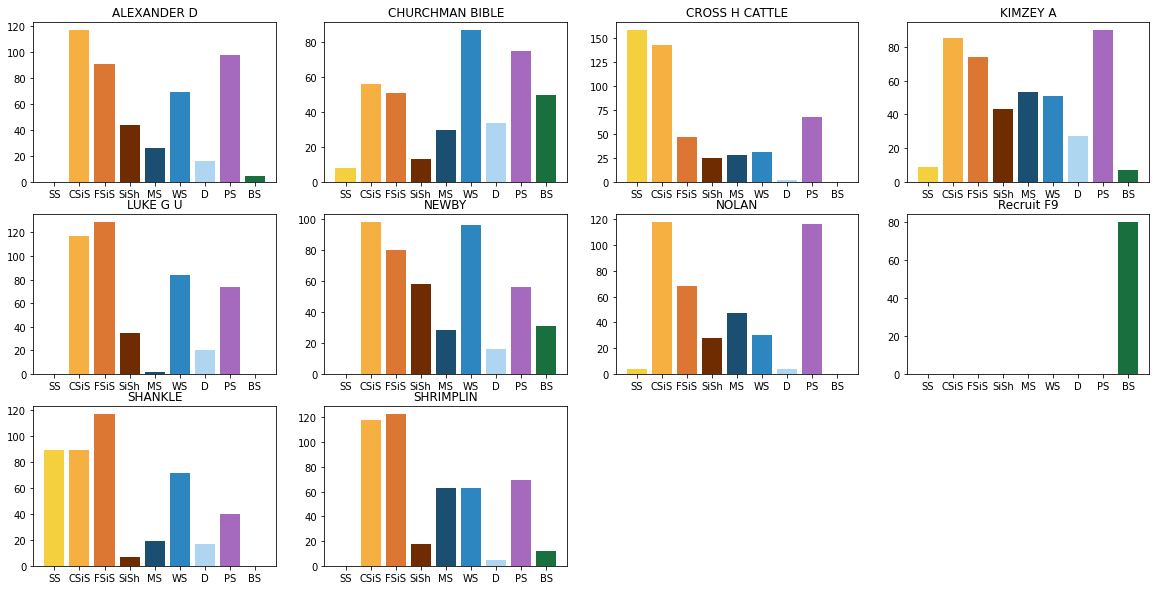

In [5]:
# workaround to increase figure size
mpl.rcParams['figure.figsize'] = (20.0, 10.0)
inline_rc = dict(mpl.rcParams)

# Data Exploration: Facies per well
for w_idx, w in enumerate(np.unique(well)):
    # Define plot ID in mosaic
    ax = plt.subplot(3, 4, w_idx+1)
    
    # Define histogram settings
    hist = np.histogram(y[well == w], bins=np.arange(len(facies_names)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    
    # Cosmetic settings
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
    ax.set_title(w)

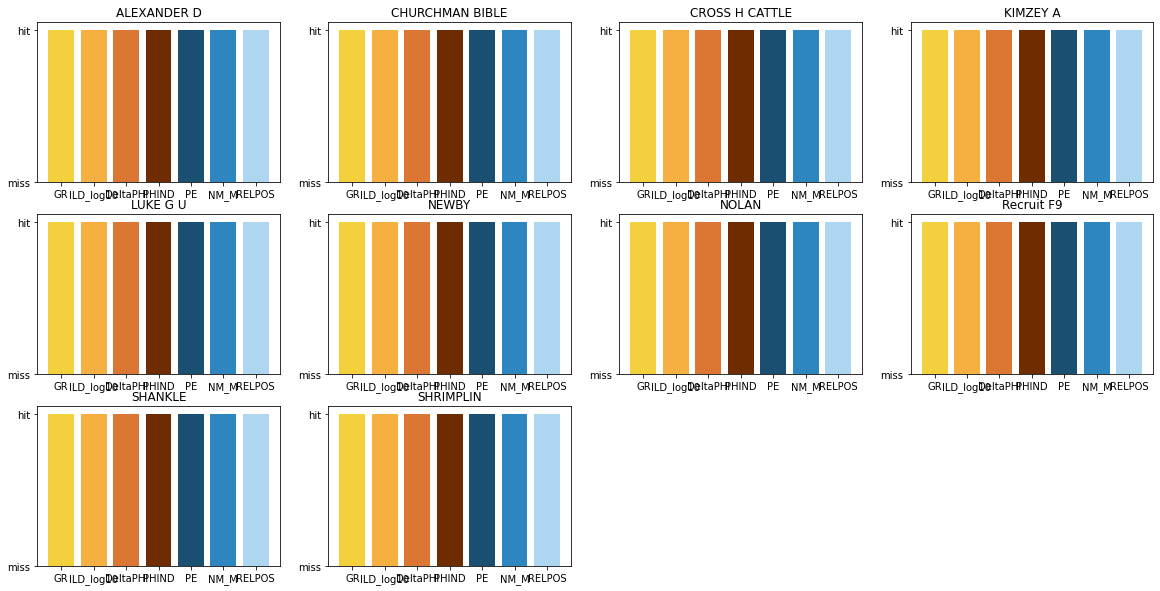

In [6]:
# Data Exploration: Features per well present/missing? Imputing filled all missing PE!
for w_idx, w in enumerate(np.unique(well)):
    # Define plot ID in mosaic
    ax = plt.subplot(3, 4, w_idx+1)
    
    # Define histogram settings
    hist = np.logical_not(np.any(np.isnan(X[well == w, :]), axis=0))
    plt.bar(np.arange(len(hist)), hist, color=facies_colors, align='center')
    
    # Cosmetic settings
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(feature_names)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['miss', 'hit'])
    ax.set_title(w)

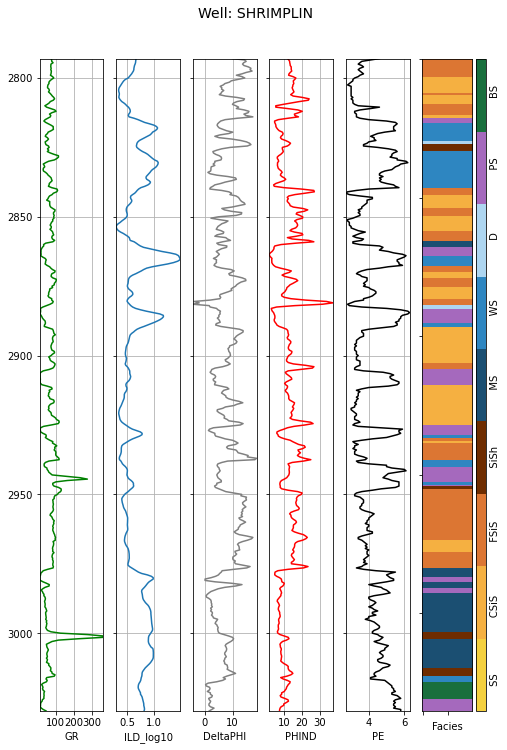

In [7]:
make_facies_log_plot(data[data['Well Name'] == 'SHRIMPLIN'], pred_column='Facies', facies_colors=facies_colors)

## 3. Augmentation

In [8]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

## 4. Train, then Predict Test Facies

In [15]:
search_space = {"colsample_bylevel": Real(0.6,1),
                "colsample_bytree":Real(0.6, 0.8),
                "gamma": Real(0.01,5), 
                "learning_rate": Real(0.0001, 1),
                "max_delta_step": Real(0.1, 10),
                "max_depth": Integer(3, 15),
                "min_child_weight": Real(1, 500),
                "n_estimators": Integer(10,200),
                "reg_alpha": Real(0.1,100),
                "reg_lambda": (0.1, 100),
                "subsample": (0.4, 1.0)
                }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = XGB_bayes_search.best_score_
    print("best train score: {}".format(score))

    
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_ts, well_ts):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)
    
    # Train classifier
    clf = XGBClassifier()
    global XGB_bayes_search
    XGB_bayes_search = BayesSearchCV(clf, search_space, n_iter=75, scoring="f1_weighted", n_jobs=-1, cv=5)
    
    XGB_bayes_search.fit(X_tr, y_tr, callback=on_step)
    
    # Test classifier
    y_ts_hat = XGB_bayes_search.predict(X_ts)
    
    # Clean isolated facies for each well
    for w in np.unique(well_ts):
        y_ts_hat[well_ts==w] = medfilt(y_ts_hat[well_ts==w], kernel_size=5)
    
    return y_ts_hat

In [16]:
# Load testing data
test_data = pd.read_csv('validation_data_nofacies.csv')

# Prepare training data
X_tr = X
y_tr = y

# Augment train features
X_tr, padded_rows = augment_features(X_tr, well, depth)

# Removed padded rows
X_tr = np.delete(X_tr, padded_rows, axis=0)
y_tr = np.delete(y_tr, padded_rows, axis=0) 

# Prepare test data
well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values

# Augment test features
X_ts, padded_rows = augment_features(X_ts, well_ts, depth_ts)

# Predict test labels
y_ts_hat = train_and_test(X_tr, y_tr, X_ts, well_ts)
# Add prediction to test_data for plotting
test_data['Prediction'] = y_ts_hat
# Save predicted test labels
test_data.to_csv('Test_Facies_Prediction.csv')

# Predict train labels, 
y_tr_hat = XGB_bayes_search.predict(X_tr)
# Add prediction to data for plotting
data = data.join(pd.DataFrame(y_tr_hat), how='inner')
data.rename(columns={0: "Prediction"}, inplace=True)

print("\nBest score: {}\nBest params: {}".format(XGB_bayes_search.best_score_,XGB_bayes_search.best_params_))

best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5361553612441909
best train score: 0.5376718365791453
best train score: 0.5376718365791453
best train score: 0.542946198365008
best train score: 0.542946198365008
best train score: 0.542946198365008
best train score: 0.542946198365008
best train score: 0.542946198365008
best train score: 0.542946198365008
best train score: 0.542946198365008
best train score: 0.5545943883214852
best train score: 0.5545943883214852
best train score: 0.5545943883214852
best train score: 0.5545943883214852
best train score: 0.5545943883214852
best train score: 0.5549858484990156
best train score: 0.5549858484990156
best train score: 0.5549858484990156
best tra

## 5. Evaluate Train and Test Wells

In [11]:
# F1 score on test wells

y_ts_true = pd.read_csv('blind_stuart_crawford_core_facies.csv')
# rename columns for merging
y_ts_true.rename(columns={'Depth.ft': 'Depth', 'LithCode': 'Facies'}, inplace=True)
# remove facies "11", since that was not in training
y_ts_true = y_ts_true[y_ts_true!=11]

test_data = test_data.merge(y_ts_true, on='Depth', how='inner')
test_data.dropna(inplace=True)
print("F1_weighted: ",f1_score(test_data['Facies'], test_data['Prediction'], average='weighted'))

F1_weighted:  0.4788532771575889


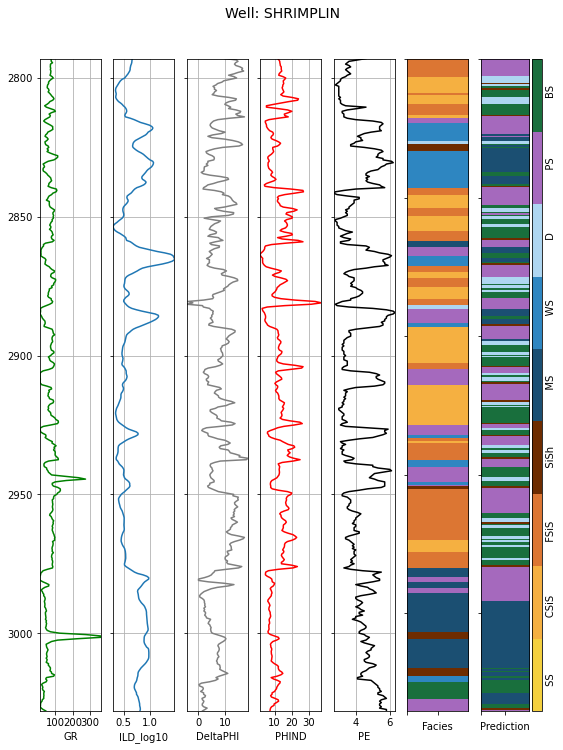

In [12]:
# Compare true and predicted facies on first TRAINING well
compare_facies_plot(data[data['Well Name'] == 'SHRIMPLIN'], pred_column='Prediction', facies_colors=facies_colors)

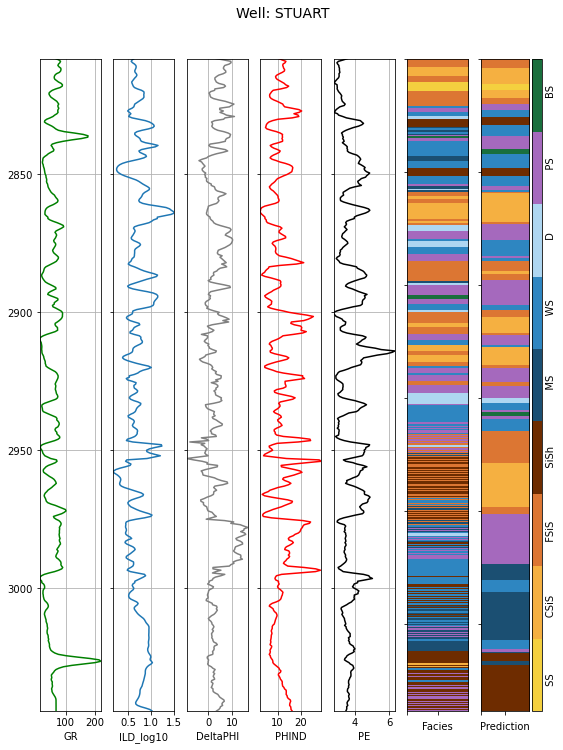

In [13]:
# Compare true and predicted facies on first TEST well
compare_facies_plot(test_data[test_data['Well Name'] == 'STUART'], pred_column='Prediction', facies_colors=facies_colors)

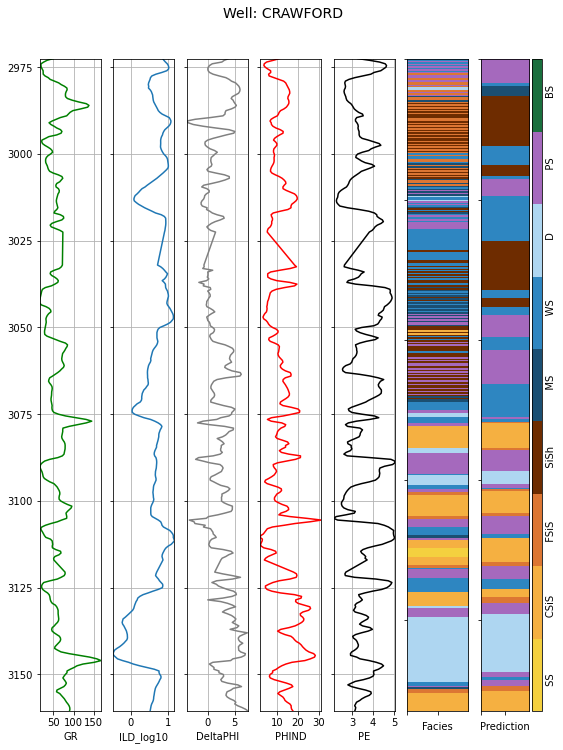

In [14]:
# Compare true and predicted facies on second TEST well
compare_facies_plot(test_data[test_data['Well Name'] == 'CRAWFORD'], pred_column='Prediction', facies_colors=facies_colors)